In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import time
import torch
import torchaudio

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import numpy as np
import pylab as plt

# Distill Whisper with a RQ bottleneck (588hrs)

In [ ]:
# load all embeddings
frames = []
tokens = []
mb = master_bar(list(Path(f'/mnt/whisper-distil/').glob('whisper-tiny-decoder-*')))
for dirname in mb:
    for name in progress_bar(list(dirname.rglob('*.whisper')), parent=mb):
        frames.append(torch.load(name))
        tokens += torch.load(name.with_suffix('.tokens'))

# this uses too much RAM, we'll have to work around that:
# frames = torch.cat(frames)
# frames.shape

In [ ]:
frames_Ns = [f.shape[0] for f in frames]

In [ ]:
sum(frames_Ns)

70560

In [ ]:
frames[-1].shape

torch.Size([12, 1, 1500, 384])

In [ ]:
# frames is a list of tensors with multiple samples in each tensor
all_samples = [(i,j) for i,N in enumerate(frames_Ns) for j in range(N)]

In [ ]:
# tokens on the other hand are one concatenated list, we have to make a mapping to find them
token_offs = np.cumsum([0] + frames_Ns)

In [ ]:
all_samples[-1]

(2587, 11)

In [ ]:
token_offs

array([    0,     3,    38, ..., 70529, 70548, 70560])

In [ ]:
import whisper
whmodel = whisper.load_model('tiny.en')
tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')

In [ ]:
# the total token count (keep in mind we have 50k+ unique tokens...)
sum([len(t) for t in tokens])

6656655

In [ ]:
# the audio length (in hours)
sum(frames_Ns) * 30 / 60 / 60

588.0

In [ ]:
import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)
    
class RQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, q_depth=12, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(RQBottleneckTransformer, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.rq = ResidualVQ(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
            num_quantizers= q_depth,
        )
        
        self.ce_lossf = nn.CrossEntropyLoss()
        self.kl_lossf = nn.KLDivLoss(reduction='batchmean')

        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)

    def encode(self, xin):
        x = self.ln_vq(self.in_blocks(xin))
        _, indices, _ = self.rq(x)
        return indices
        
    def forward(self, xin, tokens=False):
        x = self.ln_vq(self.in_blocks(xin))
        quantized, self.indices, self.commit_loss = self.rq(x)
        self.commit_loss = self.commit_loss.mean()
        x = self.ln_post(self.out_blocks(quantized))
        self.err = torch.tensor(torch.nan)
        if tokens is not False:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                whmodel.eval()
                teacher_logits = whmodel.decoder(ts, xin)
                whmodel.train()
            logits = whmodel.decoder(ts, x)
            self.ce_loss = self.ce_lossf(logits.view(-1,logits.shape[-1]), torch.tensor(tokens + [tokenizer.eot]).cuda().view(-1))
            self.kl_loss = self.kl_lossf(F.log_softmax(logits, dim=-1), F.softmax(teacher_logits, dim=-1))
            loss = self.ce_loss + self.kl_loss + self.commit_loss
            return x, loss
        else:
            return x

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
import random
import IPython

def train(vqmodel, xs, ys, split=0.01, Loss=nn.L1Loss(), lr=1e-4, weight_decay=0.1, pct_start=0.3, warmup=5000, warmup_mul=1e-2, epochs=10, scheduler=None):
    all_params = set(vqmodel.parameters())
    wd_params = set()
    for m in vqmodel.modules():
        if isinstance(m, nn.Linear):
            wd_params.add(m.weight)
            if m.bias is not None:
                wd_params.add(m.bias)
    no_wd_params = all_params - wd_params
    
    optimizer = torch.optim.AdamW(lr=lr * warmup_mul, betas=(0.9, 0.95), #fused=True,
        params=[
            {"params": list(wd_params), "weight_decay": weight_decay},
            {"params": list(no_wd_params), "weight_decay": 0.0},
        ]
    )

    idxs = all_samples[:]
    random.shuffle(idxs)
    val_n = int(split * len(idxs))
    train_idxs, val_idxs = idxs[:-val_n], idxs[-val_n:]
    run_valid_every_iters = len(train_idxs)//30

    q_depth = len(vqmodel.rq.layers)
    gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1])
    vq_gs = gs[1].subgridspec(1, q_depth)
    codebook_gs = gs[2].subgridspec(1, q_depth)
    graph_fig = plt.figure(figsize=(10,6))
    loss_p = graph_fig.add_subplot(gs[0])
    vq_p = [graph_fig.add_subplot(vq_gs[i]) for i in range(q_depth)]
    codebook_p = [graph_fig.add_subplot(codebook_gs[i]) for i in range(q_depth)]
    graph_out = display(graph_fig, display_id=True, clear=True)
    
    it = 0
    max_vq_usage = [5]*q_depth
    vq_range = torch.tensor([-2,2,-2,2]).repeat(q_depth,1)
    its = [torch.nan]
    train_losses = [torch.nan]
    val_losses = [torch.nan]
    commit_loss = torch.nan
    ce_loss = torch.nan
    kl_loss = torch.nan
    mb = master_bar(range(epochs))
    mb.write(["train", "val"], table=True)
    running_loss = [0]
    for epoch in mb:
        val_loss = 0
        bar = progress_bar(train_idxs, parent=mb)
        for step,(i,j) in enumerate(bar):
            # zero the parameter gradients
            optimizer.zero_grad()

            ps, loss = vqmodel(xs[i][j].cuda().to(torch.float32), ys[token_offs[i] + j])
            loss.backward()
            optimizer.step()
            if it == warmup:
                scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=pct_start, steps_per_epoch=len(train_idxs), epochs=epochs)
            if it > warmup:
                # warmup
                scheduler.step()

            running_loss.append(loss.item())
            running_loss = running_loss[-100:]
            if it % run_valid_every_iters == 50:
                its.append(it)
                train_losses.append(sum(running_loss)/len(running_loss))
                vqmodel.eval()
                with torch.no_grad():
                    loss = 0
                    commit_loss = 0
                    ce_loss = 0
                    kl_loss = 0
                    for i,j in val_idxs:
                        ps, _loss = vqmodel(xs[i][j].cuda().to(torch.float32), ys[token_offs[i] + j])
                        loss += _loss
                        commit_loss += vqmodel.commit_loss
                        ce_loss += vqmodel.ce_loss
                        kl_loss += vqmodel.kl_loss
                    N = len(val_idxs)
                    loss = loss.item() / N; commit_loss = commit_loss.item() / N; ce_loss = ce_loss.item() / N; kl_loss = kl_loss.item() / N;
                vqmodel.train()
                val_losses.append(loss)
                loss_p.clear()
                loss_p.plot(its, train_losses)
                loss_p.plot(its, val_losses)
                loss_p.set_xlim(0, epochs * len(train_idxs))
                loss_p.set_yscale('log')
                for i in range(q_depth):
                    vq = vqmodel.rq.layers[i]
                    cls = vq._codebook.cluster_size
                    vq_p[i].clear()
                    vq_p[i].fill_between(range(cls.shape[1]), 0, torch.sort(cls, descending=True).values.cpu().numpy()[0])
                    vq_p[i].margins(0,0)
                    vq_p[i].spines['top'].set_visible(False)
                    vq_p[i].spines['right'].set_visible(False)
                    vq_p[i].spines['bottom'].set_visible(False)
                    vq_p[i].spines['left'].set_visible(False)
                    vq_p[i].set_ylim(0, max_vq_usage[i])
                    used_codes = (cls > 0.1).sum()
                    vq_p[i].text(0.5, 0.9, f'{int(used_codes)}', horizontalalignment='center',
                         verticalalignment='center', transform=vq_p[i].transAxes)
                    cd = vq._codebook.embed
                    codebook_p[i].clear()
                    codebook_p[i].scatter(vq.codebook[:,0].cpu(), vq.codebook[:,1].cpu(), s=vq._codebook.cluster_size.cpu(), alpha=.2)
                    codebook_p[i].set_xlim(*vq_range[i][0:2])
                    codebook_p[i].set_ylim(*vq_range[i][2:4])
                graph_out.update(graph_fig)

            it += 1
            bar.comment = f"#{epoch+1}/{epochs} loss: {sum(running_loss) / len(running_loss):.3f} / {val_losses[-1]:.3f} commit: {commit_loss:.3f} ce: {ce_loss:.3f} kl: {kl_loss:.3f}"
        mb.write([f"{train_losses[-1]:.3f}", f"{val_losses[-1]:.3f}"], table=True)
    graph_out.update(IPython.display.HTML(''))

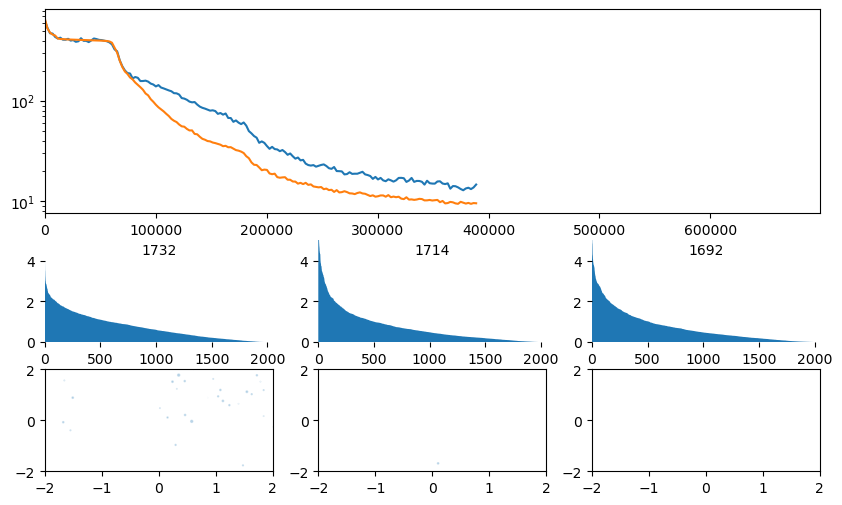

train,val
255.175,252.888
92.039,46.431
33.051,18.754
18.741,11.717
14.933,10.113


KeyboardInterrupt: 

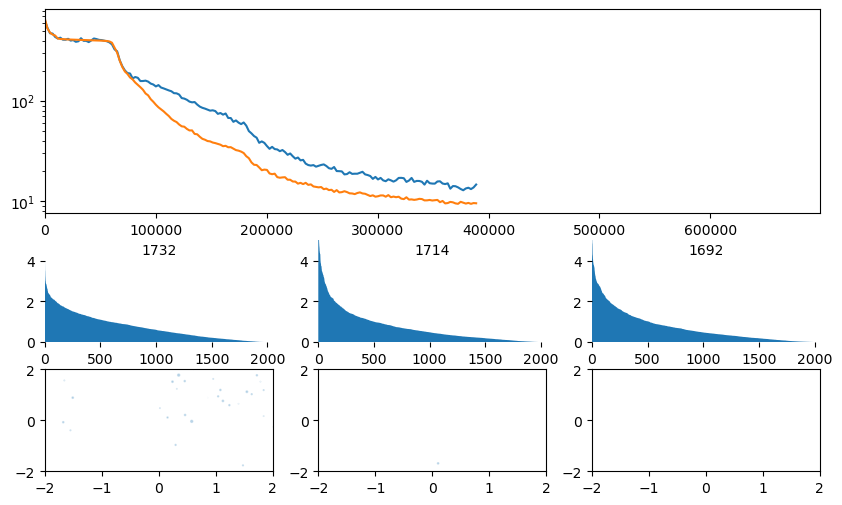

In [ ]:
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=10, lr=1e-4, warmup_mul=1e-3, warmup=10000)

## Check the decoder performance with and without the RQ bottleneck

In [ ]:
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), frames[0][0].cuda()).argmax(-1)[0])

' Richard Corrie by Edwin Arlington Robinson, read for librovox.org by Fox and the stars of shininghalf.com. Whenever Richard Corrie went downtown, we people on the pavement looked at him. He He was a gentleman from Seoul to crown, clean favored, and impurially slim.<|endoftext|>'

In [ ]:
# probably a bit better with more data, good enough for now
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), vqmodel(frames[0][0].cuda().to(torch.float32))).argmax(-1)[0])

'<|nospeech|> Richard Coryrie by Edwin Arlington Robinson, read for Libroox.org by Fox in the Stars of shining half.com. Whenever Richard Corrie went downtown, we people on the pavement looked at him. He He was a gentleman from sold to Crown, clean favored and and impurially slim.<|endoftext|>'

### Save the model

In [ ]:
torch.save(vqmodel.state_dict(), 'vqmodel-tiny-600h.pth')

In [ ]:
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1)
vqmodel.load_state_dict(torch.load('vqmodel-tiny-600h.pth'))
vqmodel.eval().cuda()

RQBottleneckTransformer(
  (in_blocks): Sequential(
    (0): ResidualAttentionBlock(
      (attn): MultiHeadAttention(
        (query): Linear(in_features=384, out_features=384, bias=True)
        (key): Linear(in_features=384, out_features=384, bias=False)
        (value): Linear(in_features=384, out_features=384, bias=True)
        (out): Linear(in_features=384, out_features=384, bias=True)
      )
      (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=384, out_features=1536, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1536, out_features=384, bias=True)
      )
      (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
  (ln_vq): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (rq): ResidualVQ(
    (layers): ModuleList(
      (0): VectorQuantize(
        (project_in): Linear(in_features=384, out_features=16, bias=True)
        (project_out): Linea

In [ ]:
frames[0].cuda().to(torch.float32).shape

torch.Size([3, 1, 1500, 384])

In [ ]:
vqmodel.encode(frames[0].cuda().to(torch.float32).squeeze(1)).shape

torch.Size([3, 1500, 3])

### Generate and save all semantic tokens (semtoks)

In [ ]:
mb = master_bar(list(Path(f'/mnt/whisper-distil/').glob('whisper-tiny-decoder-*')))
for dirname in mb:
    for name in progress_bar(list(dirname.rglob('*.whisper')), parent=mb):
        semtoks = vqmodel.encode(torch.load(name).cuda().to(torch.float32).squeeze(1))
        torch.save(semtoks.to(torch.int16).cpu(), name.with_suffix('.semtok'))